# prophet을 사용한 시계열 예측
- https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
- 페이스북 https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/
- 단변수 예측
- 데이터프레임 구조로 입력
- in-sample and out-of-sample forecasts
- trends, seasonality, and holidays 지원

In [1]:
!pip install fbprophet

In [1]:
import fbprophet
print('Prophet %s' % fbprophet.__version__)

Prophet 0.6


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'retina'

## 데이터 읽기

In [3]:
path = 'https://raw.githubusercontent.com/StillWork/data/master/car_sales.csv'
df = pd.read_csv(path)
print(df.shape)

(108, 2)


In [4]:
df[:3]

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


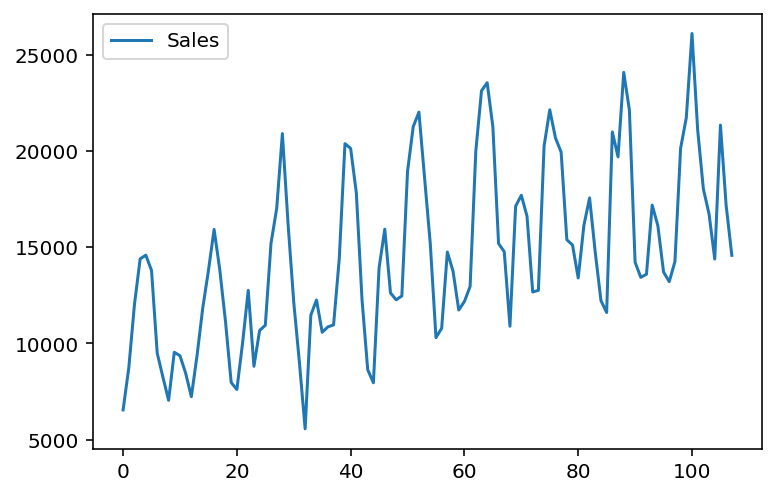

In [6]:
df.plot()
plt.show()

In [7]:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [8]:
df[:3]

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026


## 학습

In [9]:
model = Prophet()
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
df['ds'].min(), df['ds'].max(), 

(Timestamp('1960-01-01 00:00:00'), Timestamp('1968-12-01 00:00:00'))

## 향후 1년간 예측

In [11]:
future = model.make_future_dataframe(periods=12, freq='MS')
future

,ds
0,1960-01-01
1,1960-02-01
2,1960-03-01
3,1960-04-01
4,1960-05-01
...,...
115,1969-08-01
116,1969-09-01
117,1969-10-01
118,1969-11-01


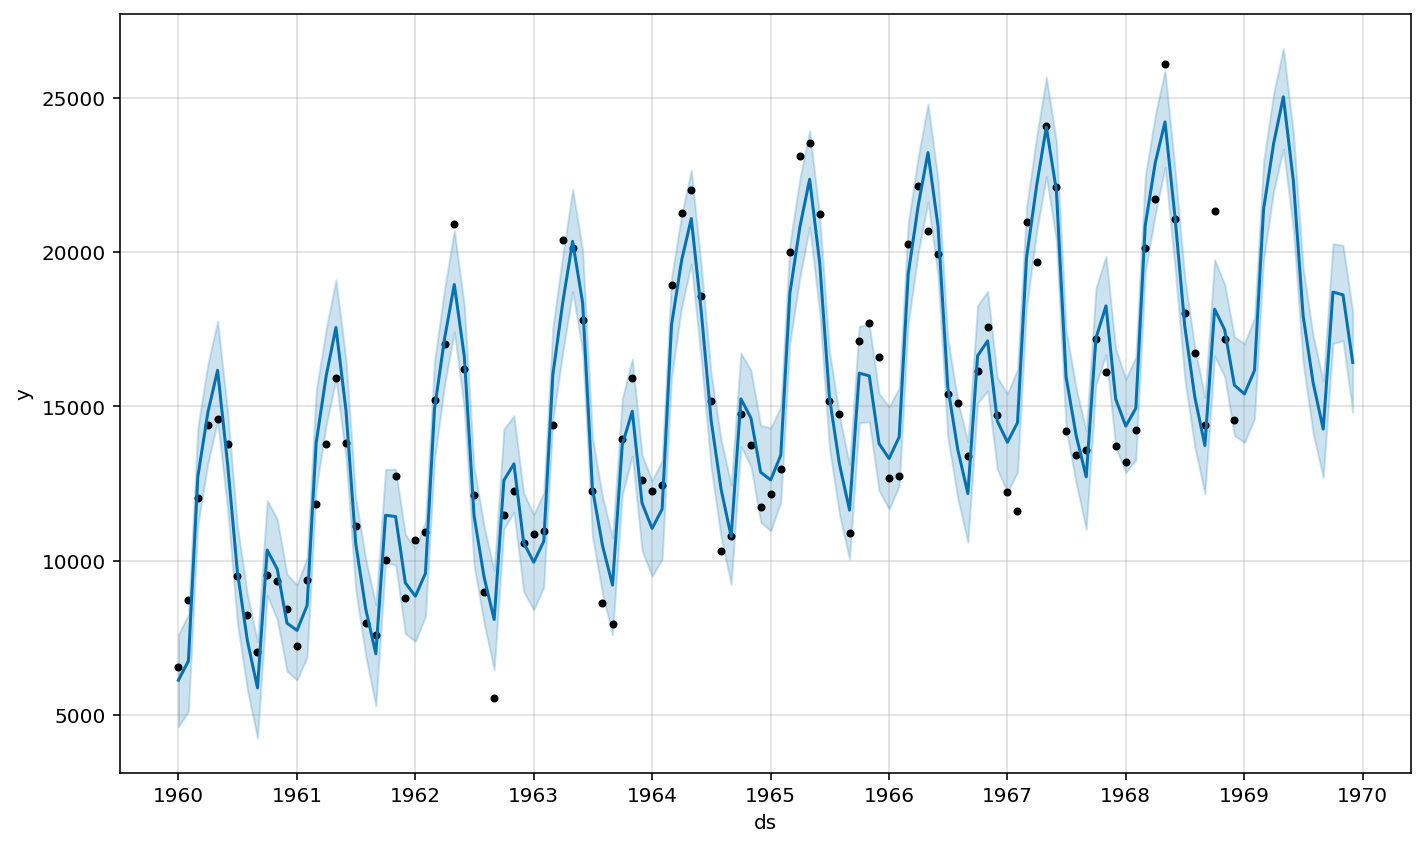

In [12]:
forecast = model.predict(future)
model.plot(forecast)
plt.show()

In [13]:
def plot_y_pred(y_test, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, c='r')
    plt.plot(y_pred, c='b')
    plt.show()
    print("R2=", r2_score(y_test, y_pred).round(3))
    error = abs(y_test - y_pred)
    print("MAE=", error.mean().round(3))
    print("rmse=", np.sqrt((error**2).mean()).round(3))
    print("max=", max(error).round(3))

## 훈련과 검증
- 최종 1년 데이터를 test 데이터로 사용

In [14]:
train = df[:-12] # 8년치 데이터
test = df[-12:] # 9년차 1년 데이터

In [15]:
future = test.drop("y", axis=1) 
future

,ds
96,1968-01-01
97,1968-02-01
98,1968-03-01
99,1968-04-01
100,1968-05-01
101,1968-06-01
102,1968-07-01
103,1968-08-01
104,1968-09-01
105,1968-10-01


In [16]:
model = Prophet()
model.fit(train)

forecast = model.predict(future)
y_pred = forecast['yhat'].values
y_test = test['y'].values

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


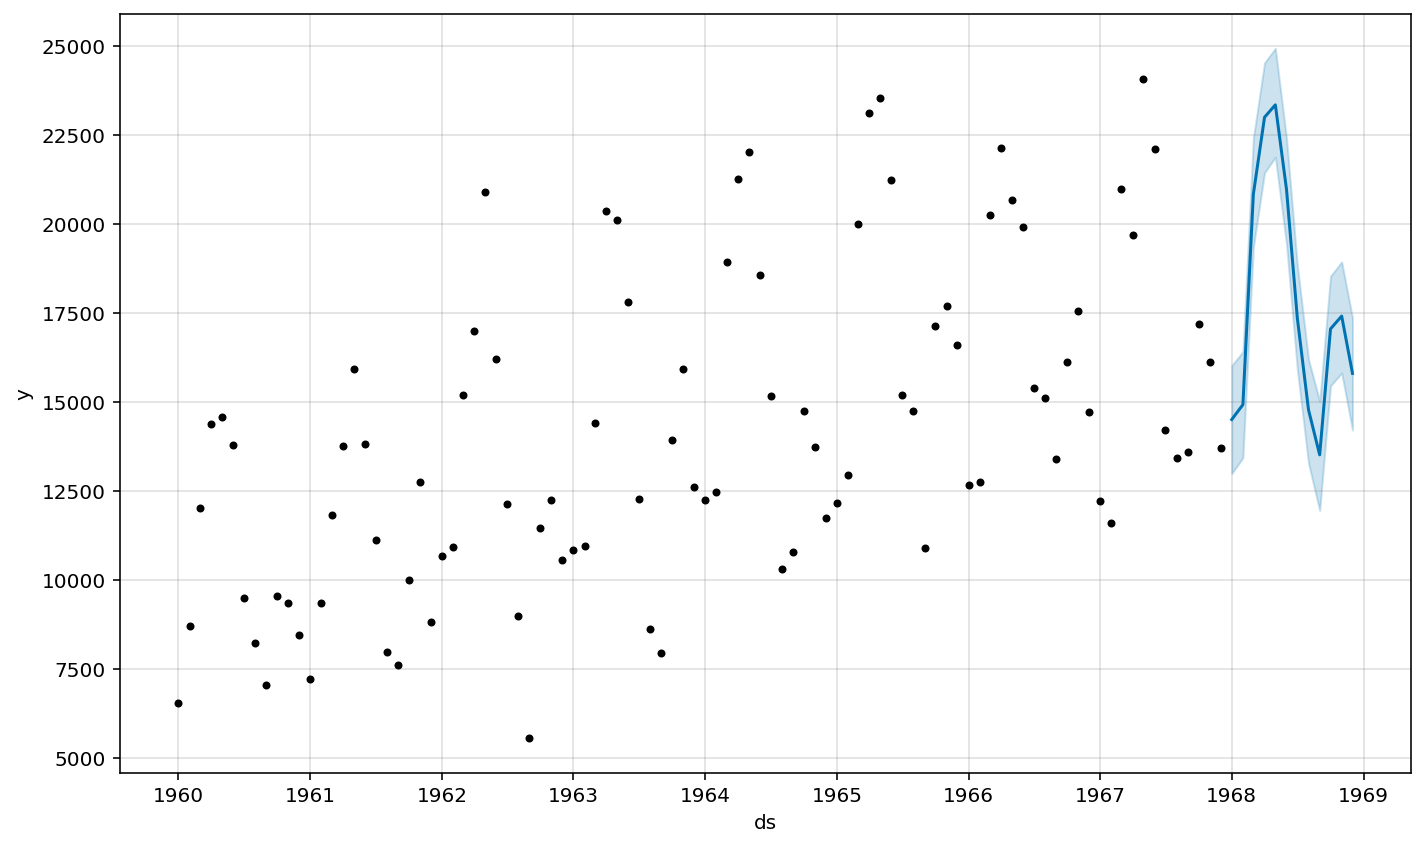

In [17]:
model.plot(forecast); plt.show()

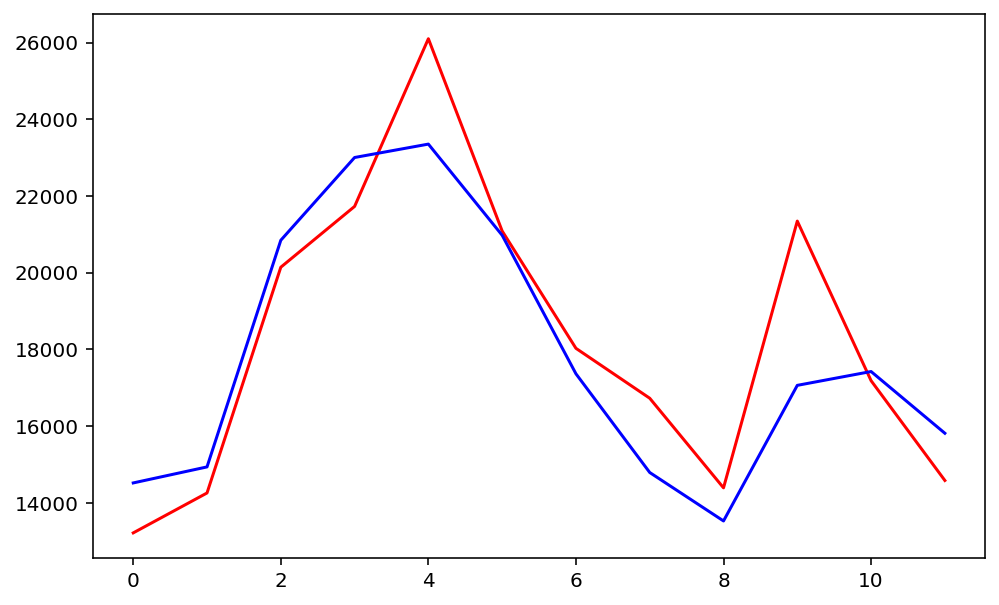

R2= 0.782
MAE= 1336.814
rmse= 1749.191
max= 4283.967


In [18]:
plot_y_pred(y_test, y_pred)

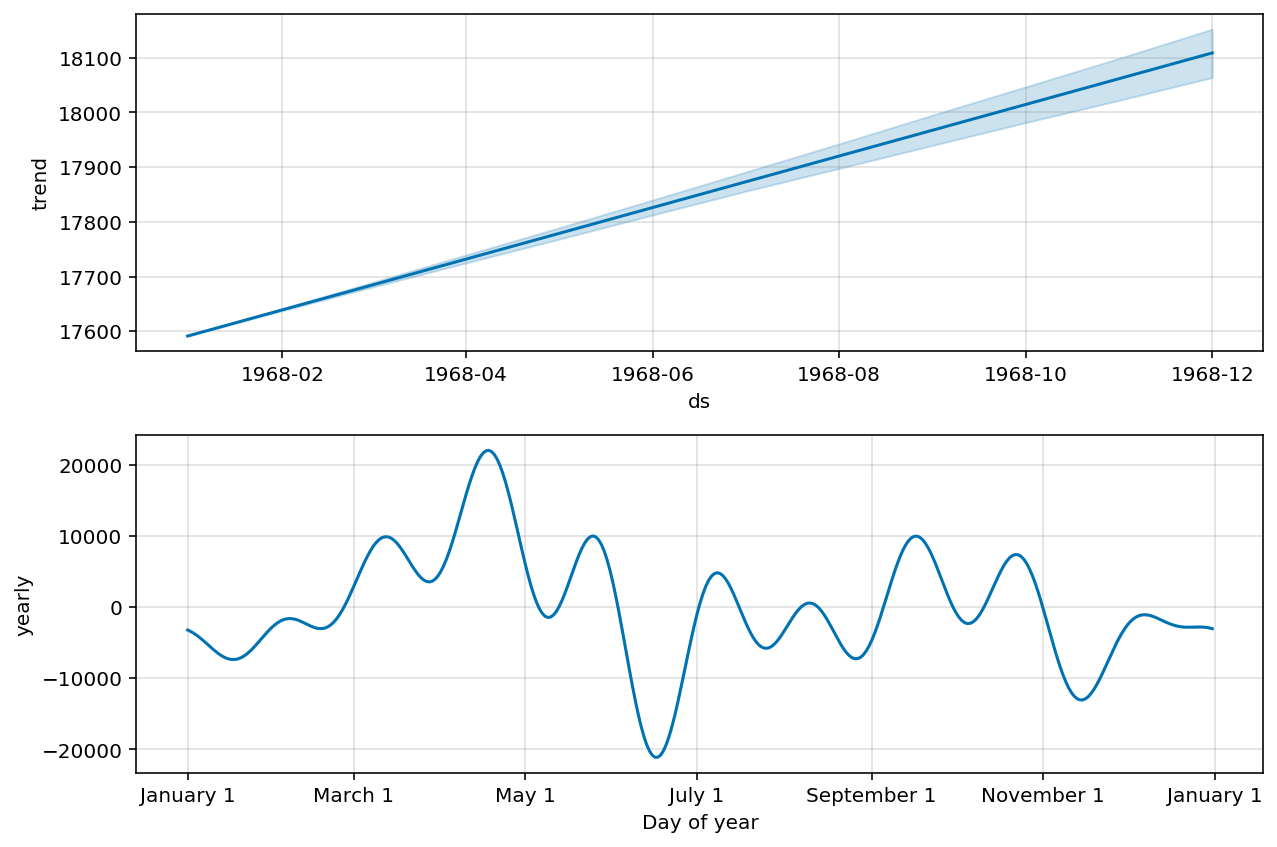

In [19]:
fig2 = model.plot_components(forecast)

# 선형 또는 naive 모델

In [20]:
def naive_model(x_seq):
    return np.array(x_seq).mean(axis=1)

In [21]:
def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - n_steps - 1 : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])
    return np.array(x), np.array(y)

In [22]:
def split_seq_2(sequence, n_steps_in, n_steps_out=1):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

In [34]:
from sklearn.linear_model import LinearRegression
y = df.y.values
cut = np.int((len(y)*0.8))
train = y[:cut]
test = y[cut:]
y.shape, train.shape, test.shape, cut

((108,), (86,), (22,), 86)

In [35]:
lr= LinearRegression()
for n_steps in range(1,20):
  x_train, y_train = split_seq(train, n_steps)
  x_test, y_test = split_seq(test, n_steps)
  lr.fit(x_train, y_train) 
  print(n_steps, lr.score(x_test, y_test).round(3))

1 0.21
2 0.109
3 0.161
4 0.129
5 0.288
6 0.41
7 0.371
8 0.35
9 0.491
10 0.504
11 0.611
12 0.766
13 0.78
14 0.707
15 0.22
16 -0.172
17 0.382
18 0.513
19 0.514


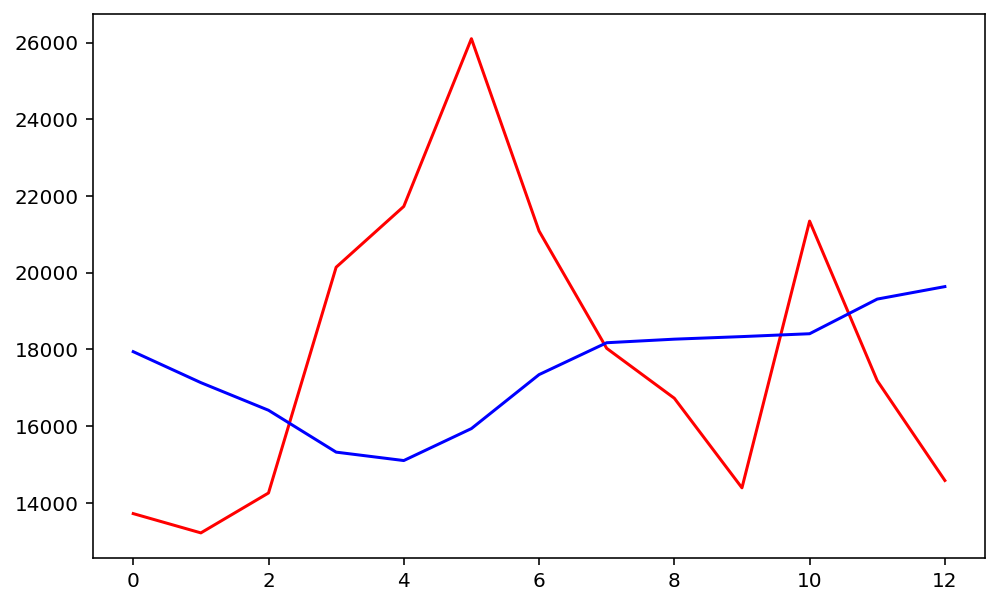

R2= -0.493
MAE= 3955.239
rmse= 4633.908
max= 10168.333


In [36]:
n_steps_in = 9
n_steps_out = 1
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
# lr.fit(x_train, y_train) 
y_pred = naive_model(x_test)
plot_y_pred(y_test, y_pred)